Context:
This data was scraped under a Academic Paper under Review by IEEE transportation

Content:
Using data from JFK airport from Nov 2019-Dec-2020, predict 'taxi-out' time of a flight using multiple linear regression with sci-kit learn. 'Taxi-out' time is how long a plane spends moving between it's gate and the runway before takeoff. Taxi-out time can impact the cost of the flight.

In [2]:
# import exploratory data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import scikit-learn modules
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Framing the problem
1. 'Taxi-out' is our labelled target variable, the one we are trying to predict. All the rest are input variables, or features, used to predict taxi-out time.
2. I will use multiple linear regression to minimise our cost function and then calculate R^2 (as well as MSE, MAE and RMSE), which measures how well our input variables measure the variance in our target variable, taxi-out time. 
3. I will then use L1 and L2 regularization to assess if different levels of alpha improve our performance metrics.
4. I will finish by using cross-validation to repeat these tests with 10-fold cross-validation to see if our first performance metrics are accurate. A low standard deviation between different folds means our R^2 is consistent across folds, and therefore the mean of our fold R^2 should be accurate.
5. I will also use RMSE and MAE to compare the performance of our models, measuring the variance in our predictions.
6. I will use GridSearchCV to find the optimal alpha value for L1 and L2 regularization.

In [3]:
# load data into dataframe
df1 = pd.read_csv('M1_final.csv')

# inspect top of dataset
print(df1.info())

# check for missing values
print(df1.isna().sum().sort_values())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28820 entries, 0 to 28819
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MONTH              28820 non-null  int64  
 1   DAY_OF_MONTH       28820 non-null  int64  
 2   DAY_OF_WEEK        28820 non-null  int64  
 3   OP_UNIQUE_CARRIER  28820 non-null  object 
 4   TAIL_NUM           28820 non-null  object 
 5   DEST               28820 non-null  object 
 6   DEP_DELAY          28820 non-null  int64  
 7   CRS_ELAPSED_TIME   28820 non-null  int64  
 8   DISTANCE           28820 non-null  int64  
 9   CRS_DEP_M          28820 non-null  int64  
 10  DEP_TIME_M         28820 non-null  int64  
 11  CRS_ARR_M          28820 non-null  int64  
 12  Temperature        28820 non-null  int64  
 13  Dew Point          28820 non-null  object 
 14  Humidity           28820 non-null  int64  
 15  Wind               28818 non-null  object 
 16  Wind Speed         288

In [4]:
# 'Wind' column is missing two values, examine missing values
missing = df1.loc[df1['Wind'].isnull()]
print(missing)

# create new dataframe, df2, with rows 15156 and 15157 dropped, where our missing values are
df2 = df1.drop([15156, 15157])

       MONTH  DAY_OF_MONTH  DAY_OF_WEEK OP_UNIQUE_CARRIER TAIL_NUM DEST  \
15156     12            19            4                B6   N648JB  FLL   
15157     12            19            4                9E   N136EV  PWM   

       DEP_DELAY  CRS_ELAPSED_TIME  DISTANCE  CRS_DEP_M  ...  Dew Point  \
15156         60               189      1069       1275  ...         10   
15157          3                83       273       1349  ...         10   

       Humidity  Wind Wind Speed  Wind Gust Pressure      Condition  sch_dep  \
15156        55   NaN          0          0    30.42  Mostly Cloudy       21   
15157        55   NaN          0          0    30.42  Mostly Cloudy       21   

       sch_arr TAXI_OUT  
15156       33       41  
15157       33       40  

[2 rows x 23 columns]


In [5]:
# check missing values have been dropped from df2
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28818 entries, 0 to 28819
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MONTH              28818 non-null  int64  
 1   DAY_OF_MONTH       28818 non-null  int64  
 2   DAY_OF_WEEK        28818 non-null  int64  
 3   OP_UNIQUE_CARRIER  28818 non-null  object 
 4   TAIL_NUM           28818 non-null  object 
 5   DEST               28818 non-null  object 
 6   DEP_DELAY          28818 non-null  int64  
 7   CRS_ELAPSED_TIME   28818 non-null  int64  
 8   DISTANCE           28818 non-null  int64  
 9   CRS_DEP_M          28818 non-null  int64  
 10  DEP_TIME_M         28818 non-null  int64  
 11  CRS_ARR_M          28818 non-null  int64  
 12  Temperature        28818 non-null  int64  
 13  Dew Point          28818 non-null  object 
 14  Humidity           28818 non-null  int64  
 15  Wind               28818 non-null  object 
 16  Wind Speed         28818 no

In [6]:
# explore our new dataset
print(df2.head())

   MONTH  DAY_OF_MONTH  DAY_OF_WEEK OP_UNIQUE_CARRIER TAIL_NUM DEST  \
0     11             1            5                B6   N828JB  CHS   
1     11             1            5                B6   N992JB  LAX   
2     11             1            5                B6   N959JB  FLL   
3     11             1            5                B6   N999JQ  MCO   
4     11             1            5                DL   N880DN  ATL   

   DEP_DELAY  CRS_ELAPSED_TIME  DISTANCE  CRS_DEP_M  ...  Dew Point  Humidity  \
0         -1               124       636        324  ...         34        58   
1         -7               371      2475        340  ...         34        58   
2         40               181      1069        301  ...         34        58   
3         -2               168       944        345  ...         34        58   
4         -4               139       760        360  ...         32        58   

   Wind Wind Speed  Wind Gust Pressure     Condition  sch_dep  sch_arr  \
0     W     

array([[<Axes: title={'center': 'MONTH'}>,
        <Axes: title={'center': 'DAY_OF_MONTH'}>,
        <Axes: title={'center': 'DAY_OF_WEEK'}>,
        <Axes: title={'center': 'DEP_DELAY'}>],
       [<Axes: title={'center': 'CRS_ELAPSED_TIME'}>,
        <Axes: title={'center': 'DISTANCE'}>,
        <Axes: title={'center': 'CRS_DEP_M'}>,
        <Axes: title={'center': 'DEP_TIME_M'}>],
       [<Axes: title={'center': 'CRS_ARR_M'}>,
        <Axes: title={'center': 'Temperature'}>,
        <Axes: title={'center': 'Humidity'}>,
        <Axes: title={'center': 'Wind Speed'}>],
       [<Axes: title={'center': 'Wind Gust'}>,
        <Axes: title={'center': 'Pressure'}>,
        <Axes: title={'center': 'sch_dep'}>,
        <Axes: title={'center': 'sch_arr'}>],
       [<Axes: title={'center': 'TAXI_OUT'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

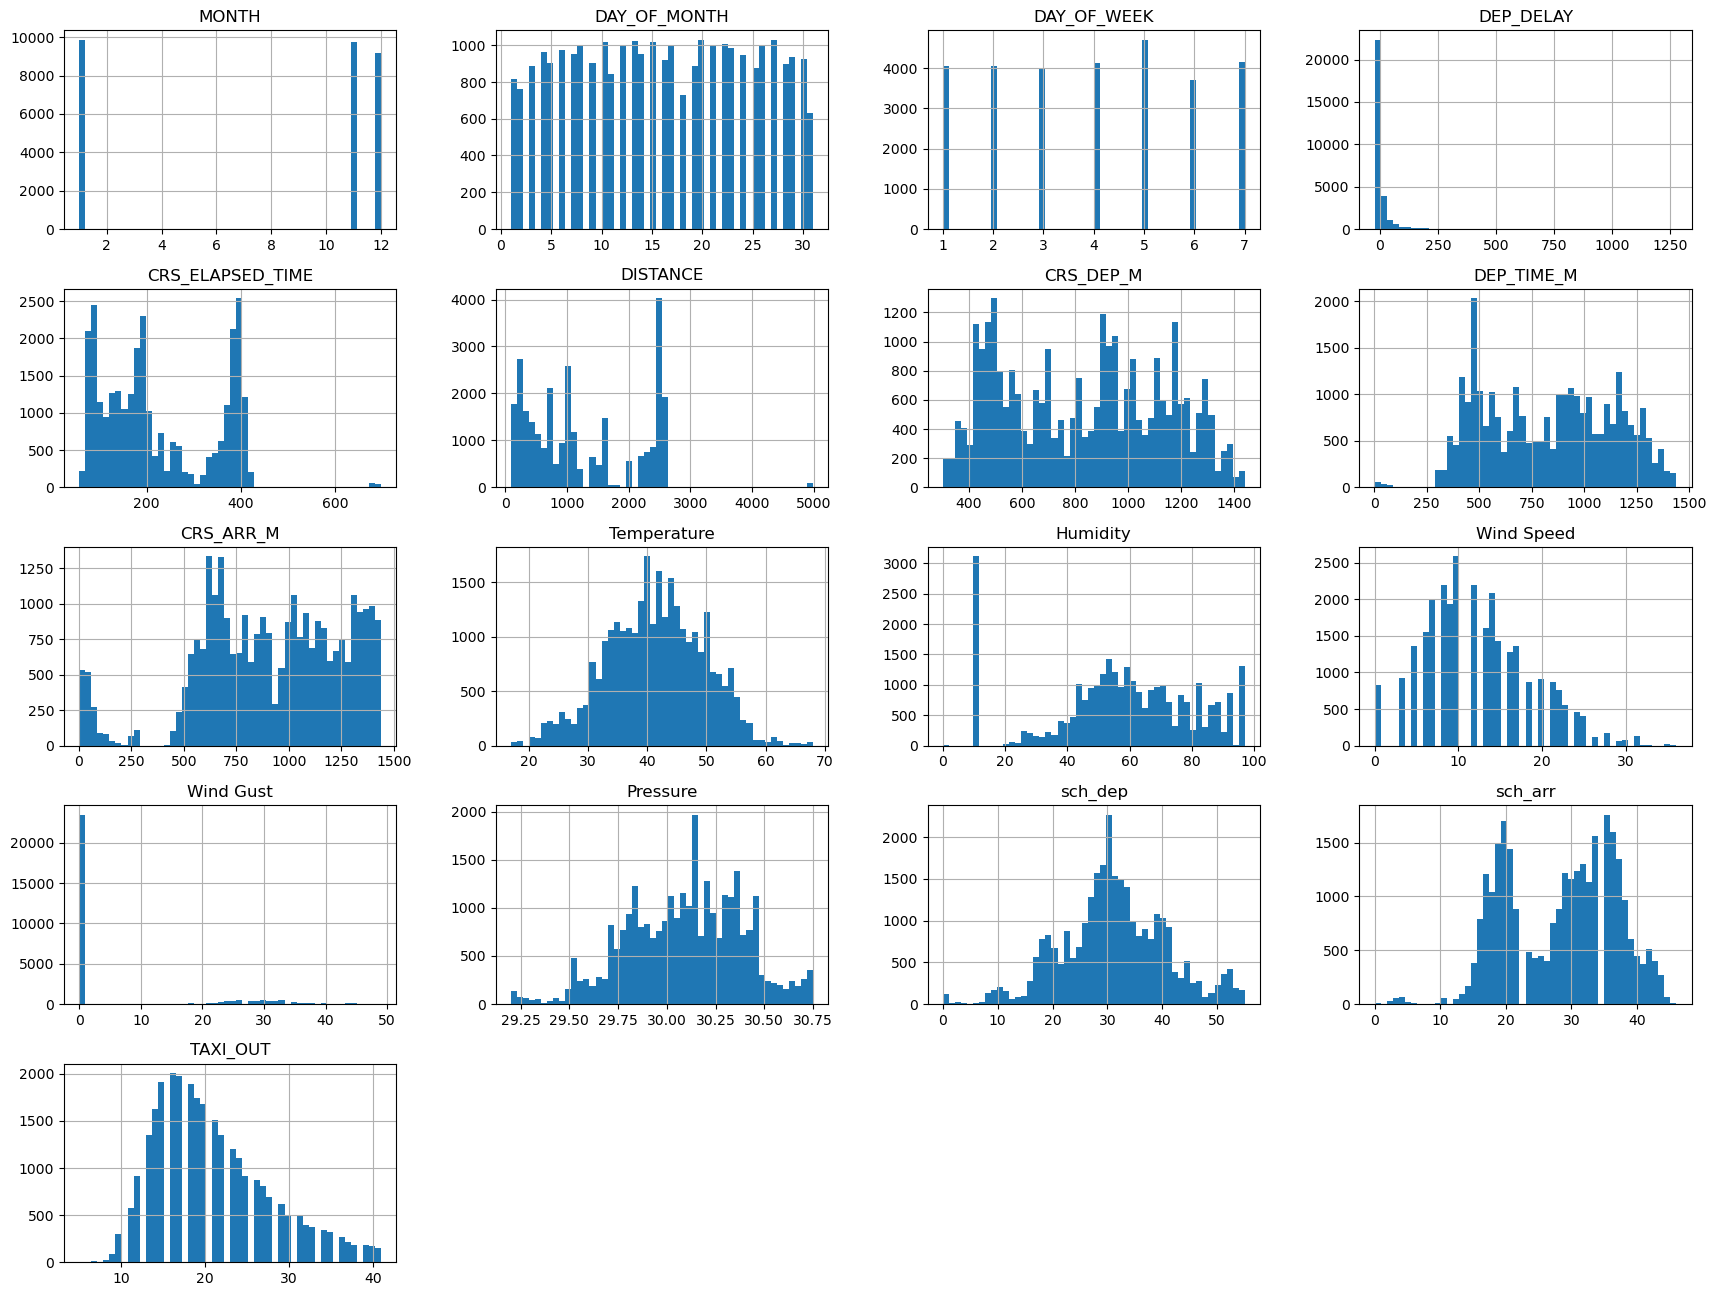

In [7]:
# visualise the distribution of each column as a histogram
df2.hist(bins=50, figsize=(21, 16))

count    28818.000000
mean        20.857207
std          6.850197
min          5.000000
25%         16.000000
50%         19.000000
75%         25.000000
max         41.000000
Name: TAXI_OUT, dtype: float64


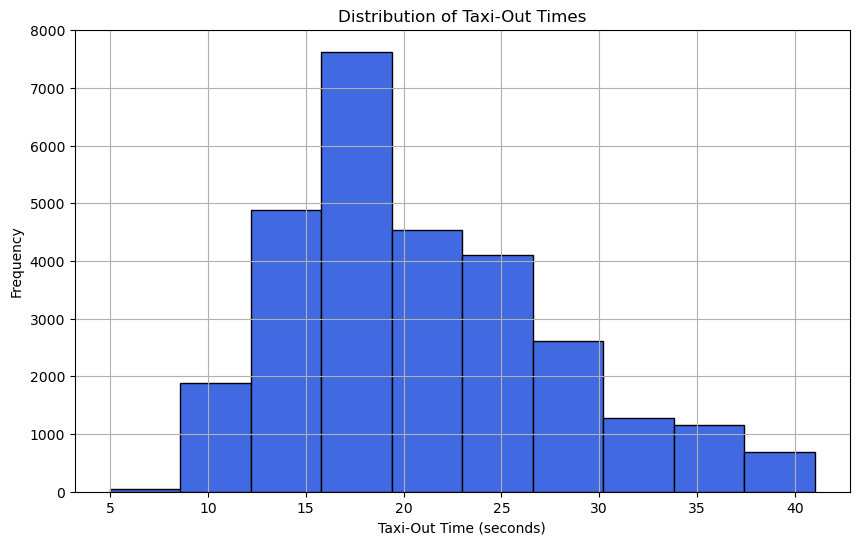

'It looks like taxi-out varies between 5 seconds and 41 seconds, \nwith a median of 19 seconds and a mean of around 21 seconds, a right-skewed distribution'

In [8]:
# examine our target variable
taxi_out = df2['TAXI_OUT']
print(taxi_out.describe())

# show taxi-out distribution
plt.figure(figsize=(10, 6))
taxi_out.hist(bins=10, color='royalblue', edgecolor='black')
plt.title('Distribution of Taxi-Out Times')
plt.xlabel('Taxi-Out Time (seconds)')
plt.ylabel('Frequency')
plt.show()

"""It looks like taxi-out varies between 5 seconds and 41 seconds, 
with a median of 19 seconds and a mean of around 21 seconds, a right-skewed distribution"""

In [9]:
"""Correlation co-efficient of our numeric variables"""

# check correlation between all variables in our dataset
numeric_df2 = df2.select_dtypes(include=[int, float])

# create correlation matrix
correlation_matrix = numeric_df2.corr()
print(correlation_matrix)


                     MONTH  DAY_OF_MONTH  DAY_OF_WEEK  DEP_DELAY  \
MONTH             1.000000     -0.007274     0.029366   0.046421   
DAY_OF_MONTH     -0.007274      1.000000    -0.029732  -0.036634   
DAY_OF_WEEK       0.029366     -0.029732     1.000000  -0.006204   
DEP_DELAY         0.046421     -0.036634    -0.006204   1.000000   
CRS_ELAPSED_TIME -0.016010      0.002779     0.000413  -0.030862   
DISTANCE         -0.000106     -0.002746     0.002450  -0.031501   
CRS_DEP_M         0.001732      0.001717     0.005412   0.102330   
DEP_TIME_M        0.002537      0.004407     0.008258   0.072275   
CRS_ARR_M        -0.012333      0.008533    -0.003340   0.043827   
Temperature       0.135832     -0.132428     0.013082  -0.032169   
Humidity          0.012522      0.096218     0.001627  -0.011771   
Wind Speed       -0.034989     -0.093178     0.095956   0.067819   
Wind Gust        -0.050989     -0.088981     0.127689   0.044363   
Pressure         -0.085342      0.016845     0.1

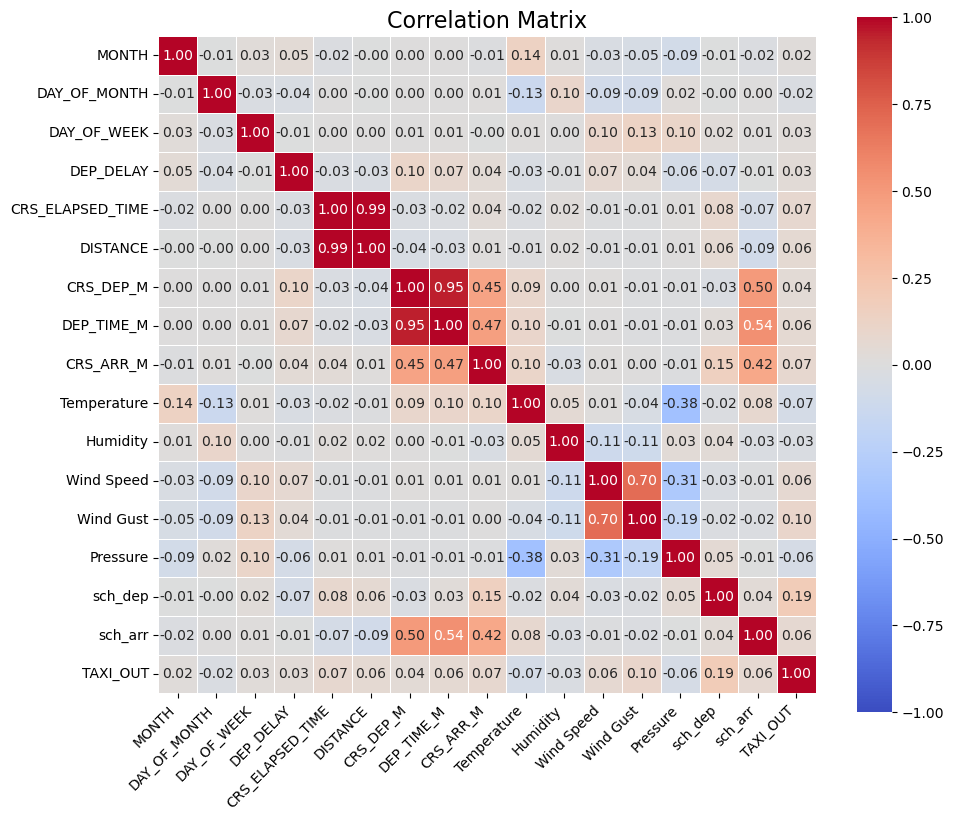

In [10]:
"""Create heatmap of correlation matrix"""

# set up the matplotlib figure
plt.figure(figsize=(10, 10))

# create a heatmap with better aesthetics
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .75})

# add title and labels
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

In [11]:
""" Convert non-numeric data types into numeric data types for linear regression.
    All columns are nominal (unranked) variables, therefore they will be one-hot encoded """

# identify non-numeric columns
categorical_df2 = df2.select_dtypes(exclude=[int, float])
print(categorical_df2.info())
print(categorical_df2.describe())
print(categorical_df2.head(5))

<class 'pandas.core.frame.DataFrame'>
Index: 28818 entries, 0 to 28819
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   OP_UNIQUE_CARRIER  28818 non-null  object
 1   TAIL_NUM           28818 non-null  object
 2   DEST               28818 non-null  object
 3   Dew Point          28818 non-null  object
 4   Wind               28818 non-null  object
 5   Condition          28818 non-null  object
dtypes: object(6)
memory usage: 1.5+ MB
None
       OP_UNIQUE_CARRIER TAIL_NUM   DEST Dew Point   Wind      Condition
count              28818    28818  28818     28818  28818          28818
unique                 9     2092     65        64     18             25
top                   B6   N102NN    LAX        33      W  Mostly Cloudy
freq                9588      108   2974      1349   3273           9122
  OP_UNIQUE_CARRIER TAIL_NUM DEST Dew Point Wind     Condition
0                B6   N828JB  CHS        34    W

In [12]:
"""One-hot encode categorical variable columns """

# one hot encode cat columns and drop any missing values
cat_cols = categorical_df2.columns
df3 = pd.get_dummies(df2, columns=cat_cols, drop_first=True)
df3.dropna()

# check shape and scale of new df3
print(df2.shape)
print(df3.shape)
print("\n", df3.describe())

(28818, 23)
(28818, 2284)

               MONTH  DAY_OF_MONTH   DAY_OF_WEEK     DEP_DELAY  \
count  28818.000000  28818.000000  28818.000000  28818.000000   
mean       7.893955     16.020890      4.008953      6.373239   
std        4.991779      8.750448      1.985299     38.735195   
min        1.000000      1.000000      1.000000    -22.000000   
25%        1.000000      8.000000      2.000000     -6.000000   
50%       11.000000     16.000000      4.000000     -3.000000   
75%       12.000000     24.000000      6.000000      2.000000   
max       12.000000     31.000000      7.000000   1276.000000   

       CRS_ELAPSED_TIME      DISTANCE     CRS_DEP_M    DEP_TIME_M  \
count      28818.000000  28818.000000  28818.000000  28818.000000   
mean         225.294399   1267.787494    830.970470    828.898987   
std          119.483432    889.354031    299.381938    305.844666   
min           57.000000     94.000000    301.000000      1.000000   
25%          124.000000    483.000000    

In [13]:
"""Scale data due to high variance, split data and convert df3 to a NumPy array"""

# define features as X and target variables as y
X = df3.drop(columns=['TAXI_OUT']).values
y = df3['TAXI_OUT'].values

# split our data into train/testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale our features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train)


[[ 0.62222346 -0.46013361 -1.01351814 ... -0.00931452 -0.05317367
  -0.00931452]
 [ 0.62222346  0.68132532  0.49728949 ... -0.00931452 -0.05317367
  -0.00931452]
 [ 0.62222346  1.25205479 -0.50991559 ... -0.00931452 -0.05317367
  -0.00931452]
 ...
 [ 0.62222346 -1.48744666  1.50449457 ... -0.00931452 -0.05317367
  -0.00931452]
 [ 0.82260816  0.56717943  1.00089203 ... -0.00931452 -0.05317367
  -0.00931452]
 [-1.3816236  -0.11769593 -0.50991559 ... -0.00931452 -0.05317367
  -0.00931452]]


In [14]:
"""Multiple linear regression to predict taxi-out and scoring"""

# create LinearRegression object
lin_reg = LinearRegression()

# train model
lin_reg.fit(X_train, y_train)

# generate prediction
lin_reg_y_prediction = lin_reg.predict(X_test)
compare_df = pd.DataFrame({'Actual value': y_test, 'Predicted value': lin_reg_y_prediction })

# check R^2 score for each train and test data
r2_train = lin_reg.score(X_train, y_train)
r2_test = lin_reg.score(X_test, y_test)


print(compare_df, "\n")

print(f"R-squared for training data: {r2_train}; R-squared for test data: {r2_test}")


      Actual value  Predicted value
0               14        24.326056
1               25        26.865315
2               25        23.511760
3               26        22.066745
4               27        29.688773
...            ...              ...
5759            10        14.627003
5760            23        15.220722
5761            19        20.089468
5762            22        23.677403
5763            15        15.610958

[5764 rows x 2 columns] 

R-squared for training data: 0.24472611486748586; R-squared for test data: 0.06948253406609517


In [15]:
# calculate MSE, RMSE, and MAE for linear regression (OLS)
mse_lin_reg = metrics.mean_squared_error(y_test, lin_reg_y_prediction)
rmse_lin_reg = np.sqrt(mse_lin_reg)
mae_lin_reg = metrics.mean_absolute_error(y_test, lin_reg_y_prediction)

print(f"Linear Regression Mean Square Error: {mse_lin_reg}")
print(f"Linear Regression Root Mean Square Error: {rmse_lin_reg}")
print(f"Linear Regression Mean Absolute Error: {mae_lin_reg}\n")

Linear Regression Mean Square Error: 42.99698268782379
Linear Regression Root Mean Square Error: 6.557208452369331
Linear Regression Mean Absolute Error: 5.1982428951680015



In [16]:
"""Due to low scores on both training and test data, test with L1 (Lasso) cross-validation"""
alpha_values = [0.01, 0.1, 1, 10, 100, 1000]
parameter_grid = {'alpha': alpha_values}

# set up KFold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# perform Lasso regression with GridSearchCV
lasso_model = Lasso()
lasso_crossv = GridSearchCV(lasso_model, parameter_grid, cv=kf, scoring='r2')
lasso_crossv.fit(X_train, y_train)

# store best Lasso alpha
best_lasso_alpha = lasso_crossv.best_params_['alpha']
best_lasso_model = lasso_crossv.best_estimator_

# store best Lasso R^2 scores
r2_lasso_train = best_lasso_model.score(X_train, y_train)
r2_lasso_test = best_lasso_model.score(X_test, y_test)

print(f"Best Lasso alpha: {best_lasso_alpha}")
print(f"R-squared for training data (Lasso): {r2_lasso_train}; R-squared for test data (Lasso): {r2_lasso_test}\n")

Best Lasso alpha: 0.1
R-squared for training data (Lasso): 0.14199296294623898; R-squared for test data (Lasso): 0.1313800242533293



In [17]:
# predictions for the best Lasso model
lasso_predictions = best_lasso_model.predict(X_test)

# calculate MSE, RMSE, and MAE for Lasso at best alpha: 1000
mse_lasso = metrics.mean_squared_error(y_test, lasso_predictions)
rmse_lasso = np.sqrt(mse_lasso)
mae_lasso = metrics.mean_absolute_error(y_test, lasso_predictions)

print(f"Lasso Mean Square Error: {mse_lasso}")
print(f"Lasso Root Mean Square Error: {rmse_lasso}")
print(f"Lasso Mean Absolute Error: {mae_lasso}\n")

Lasso Mean Square Error: 40.13684796554949
Lasso Root Mean Square Error: 6.3353648644375244
Lasso Mean Absolute Error: 5.073709163060844



In [18]:
"""Do the same for L2 (Ridge) regression """

# perform Ridge regression with GridSearchCV
ridge_model = Ridge()
ridge_crossv = GridSearchCV(ridge_model, parameter_grid, cv=kf, scoring='r2')
ridge_crossv.fit(X_train, y_train)

# store best Ridge alpha
best_ridge_alpha = ridge_crossv.best_params_['alpha']
best_ridge_model = ridge_crossv.best_estimator_

# store best Ridge R^2 scores
r2_ridge_train = best_ridge_model.score(X_train, y_train)
r2_ridge_test = best_ridge_model.score(X_test, y_test)

print(f"Best Ridge alpha: {best_ridge_alpha}")
print(f"R-squared for training data (Ridge): {r2_ridge_train}; R-squared for test data (Ridge): {r2_ridge_test}\n")

Best Ridge alpha: 1000
R-squared for training data (Ridge): 0.2416727799842624; R-squared for test data (Ridge): 0.07641495254982111



In [19]:
# predictions for the best Ridge model
ridge_predictions = best_ridge_model.predict(X_test)

# calculate MSE, RMSE, and MAE for Ridge at best alpha: 1000
mse_ridge = metrics.mean_squared_error(y_test, ridge_predictions)
rmse_ridge = np.sqrt(mse_ridge)
mae_ridge = metrics.mean_absolute_error(y_test, ridge_predictions)

print(f"Ridge Mean Square Error: {mse_ridge}")
print(f"Ridge Root Mean Square Error: {rmse_ridge}")
print(f"Ridge Mean Absolute Error: {mae_ridge}\n")

Ridge Mean Square Error: 42.67665223896933
Ridge Root Mean Square Error: 6.532736963858971
Ridge Mean Absolute Error: 5.183730777901004



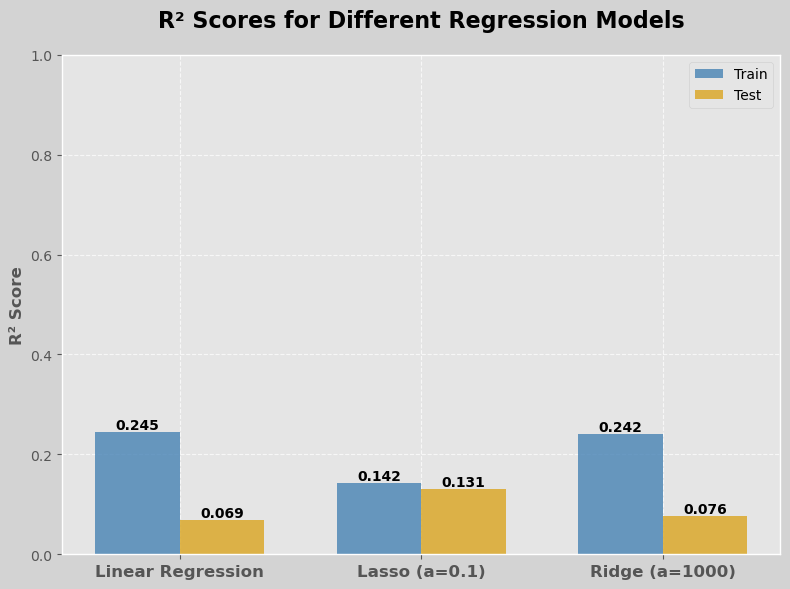

In [20]:
"""Visualise result scores to compare different metrics"""

# data for the bar chart
models = ['Linear Regression', 'Lasso (a=0.1)', 'Ridge (a=1000)']
train_scores = [r2_train, r2_lasso_train, r2_ridge_train]
test_scores = [r2_test, r2_lasso_test, r2_ridge_test]

# set up the plot with a specific style
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8, 6))

# set the width of each bar and the positions of the bars
width = 0.35
x = np.arange(len(models))

# create the bars with a slight transparency
ax.bar(x - width/2, train_scores, width, label='Train', color='steelblue', alpha=0.8)
ax.bar(x + width/2, test_scores, width, label='Test', color='goldenrod', alpha=0.8)

# customize the plot
ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax.set_title('R² Scores for Different Regression Models', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.set_ylim(0, 1)  # Set y-axis limit from 0 to 1

# add grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# add value labels on the bars
for i, v in enumerate(train_scores):
    ax.text(i - width/2, v, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
for i, v in enumerate(test_scores):
    ax.text(i + width/2, v, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# add a background color
fig.patch.set_facecolor('lightgray')

plt.tight_layout()
plt.show()

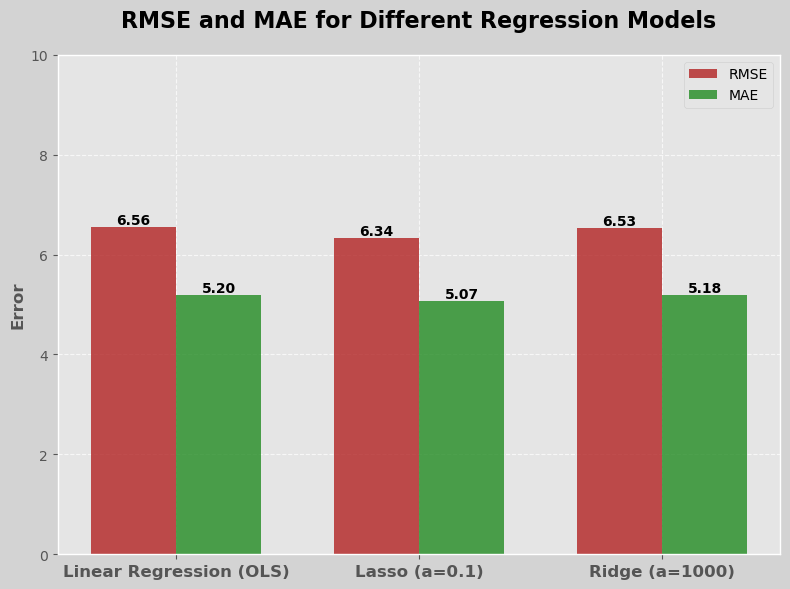

In [21]:
# data for the bar chart
models = ['Linear Regression (OLS)', 'Lasso (a=0.1)', 'Ridge (a=1000)']
rmse_scores = [rmse_lin_reg, rmse_lasso, rmse_ridge]
mae_scores = [mae_lin_reg, mae_lasso, mae_ridge]

# set up the plot with a specific style
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8, 6))

# set the width of each bar and the positions of the bars
width = 0.35
x = np.arange(len(models))

# create the bars with a slight transparency
ax.bar(x - width/2, rmse_scores, width, label='RMSE', color='firebrick', alpha=0.8)
ax.bar(x + width/2, mae_scores, width, label='MAE', color='forestgreen', alpha=0.8)

# customize the plot
ax.set_ylabel('Error', fontsize=12, fontweight='bold')
ax.set_title('RMSE and MAE for Different Regression Models', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.set_ylim(0, 10) # Set y-axis limit from 0 to 10

# add grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# add value labels on the bars
for i, v in enumerate(rmse_scores):
    ax.text(i - width/2, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')
for i, v in enumerate(mae_scores):
    ax.text(i + width/2, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# add a background color
fig.patch.set_facecolor('lightgray')

plt.tight_layout()
plt.show()

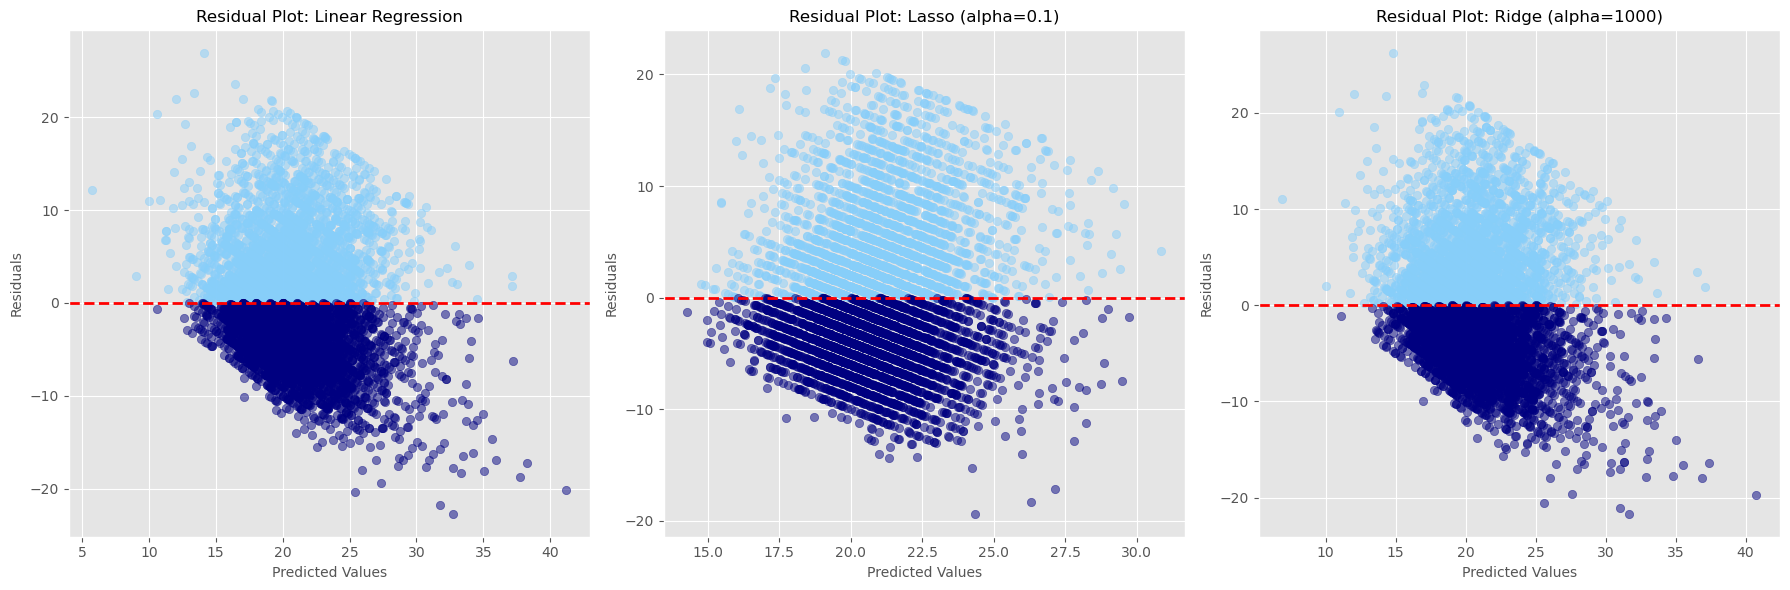

Mean of residuals (Linear Regression): -0.2327
Mean of residuals (Lasso, alpha=0.1): -0.2181
Mean of residuals (Ridge, alpha=1000): -0.2327


In [22]:
# create residual plots for Linear Regression, Lasso, and Ridge
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# linear Regression
residuals_lin = y_test - lin_reg_y_prediction
ax1.scatter(lin_reg_y_prediction[residuals_lin >= 0], residuals_lin[residuals_lin >= 0], alpha=0.5, color='lightskyblue')
ax1.scatter(lin_reg_y_prediction[residuals_lin < 0], residuals_lin[residuals_lin < 0], alpha=0.5, color='navy')
ax1.set_xlabel('Predicted Values', fontsize=10)
ax1.set_ylabel('Residuals', fontsize=10)
ax1.set_title('Residual Plot: Linear Regression', fontsize=12)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=2)

# Lasso (best alpha from GridSearchCV)
residuals_lasso = y_test - lasso_predictions
ax2.scatter(lasso_predictions[residuals_lasso >= 0], residuals_lasso[residuals_lasso >= 0], alpha=0.5, color='lightskyblue')
ax2.scatter(lasso_predictions[residuals_lasso < 0], residuals_lasso[residuals_lasso < 0], alpha=0.5, color='navy')
ax2.set_xlabel('Predicted Values', fontsize=10)
ax2.set_ylabel('Residuals', fontsize=10)
ax2.set_title(f'Residual Plot: Lasso (alpha={best_lasso_alpha})', fontsize=12)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=2)

# Ridge (best alpha from GridSearchCV)
residuals_ridge = y_test - ridge_predictions
ax3.scatter(ridge_predictions[residuals_ridge >= 0], residuals_ridge[residuals_ridge >= 0], alpha=0.5, color='lightskyblue')
ax3.scatter(ridge_predictions[residuals_ridge < 0], residuals_ridge[residuals_ridge < 0], alpha=0.5, color='navy')
ax3.set_xlabel('Predicted Values', fontsize=10)
ax3.set_ylabel('Residuals', fontsize=10)
ax3.set_title(f'Residual Plot: Ridge (alpha={best_ridge_alpha})', fontsize=12)
ax3.axhline(y=0, color='red', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

# calculate and print the mean of residuals for each model
print(f"Mean of residuals (Linear Regression): {np.mean(residuals_lin):.4f}")
print(f"Mean of residuals (Lasso, alpha={best_lasso_alpha}): {np.mean(residuals_lasso):.4f}")
print(f"Mean of residuals (Ridge, alpha={best_ridge_alpha}): {np.mean(residuals_ridge):.4f}")